In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [2]:
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]

In [3]:
protoPath = "hed_model/deploy.prototxt"
modelPath = "hed_model/hed_pretrained_bsds.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
cv2.dnn_registerLayer("Crop", CropLayer)

In [8]:
img = cv2.imread("Denoising/original_clean.tif")
(H, W) = img.shape[:2]

In [37]:
mean_pixel_values= np.average(img, axis = (0,1))
blob = cv2.dnn.blobFromImage(img, scalefactor=1, size=(W, H),
                             mean=(mean_pixel_values[0], mean_pixel_values[1], mean_pixel_values[2]),
                             swapRB= False, crop=False)

In [38]:
net.setInput(blob)
hed = net.forward()
hed = hed[0,0,:,:]  #Drop the other axes 
hed = (255 * hed).astype("uint8")

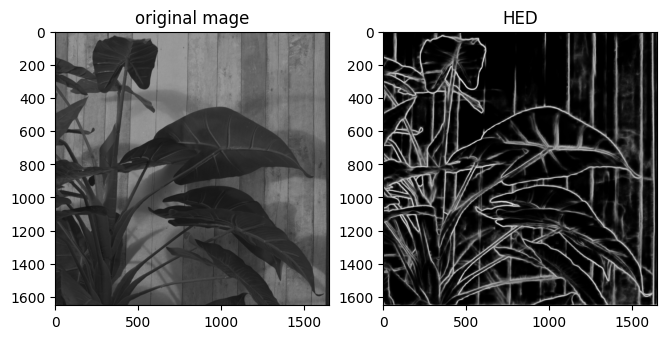

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title("original mage")
plt.imshow(img)
plt.subplot(132)
plt.title("HED")
plt.imshow(hed, cmap='gray')

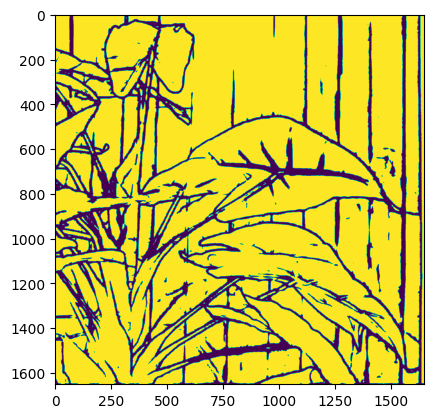

In [40]:
blur = cv2.GaussianBlur(hed, (3,3), 0)

thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

In [55]:
n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8)
n_labels

199

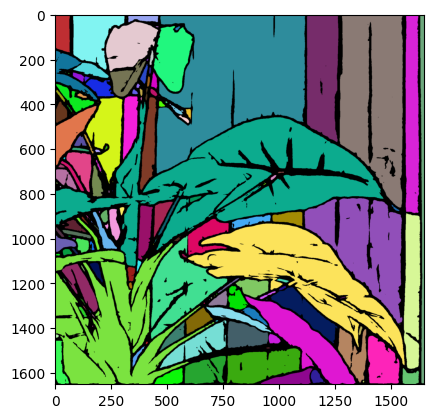

In [67]:
colors = np.random.randint(0, 255, size=(n_labels, 3), dtype=np.uint8)
colors[0] = [0, 0, 0]  # black background
false_colors = colors[labels]
plt.imshow(false_colors)

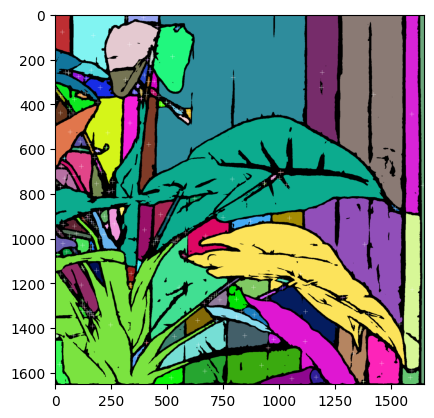

In [68]:
false_colors_centroid = false_colors.copy()
for centroid in centroids:
    cv2.drawMarker(false_colors_centroid, (int(centroid[0]), int(centroid[1])),
                   color=(255, 255, 255), markerType=cv2.MARKER_CROSS)
plt.imshow(false_colors_centroid)

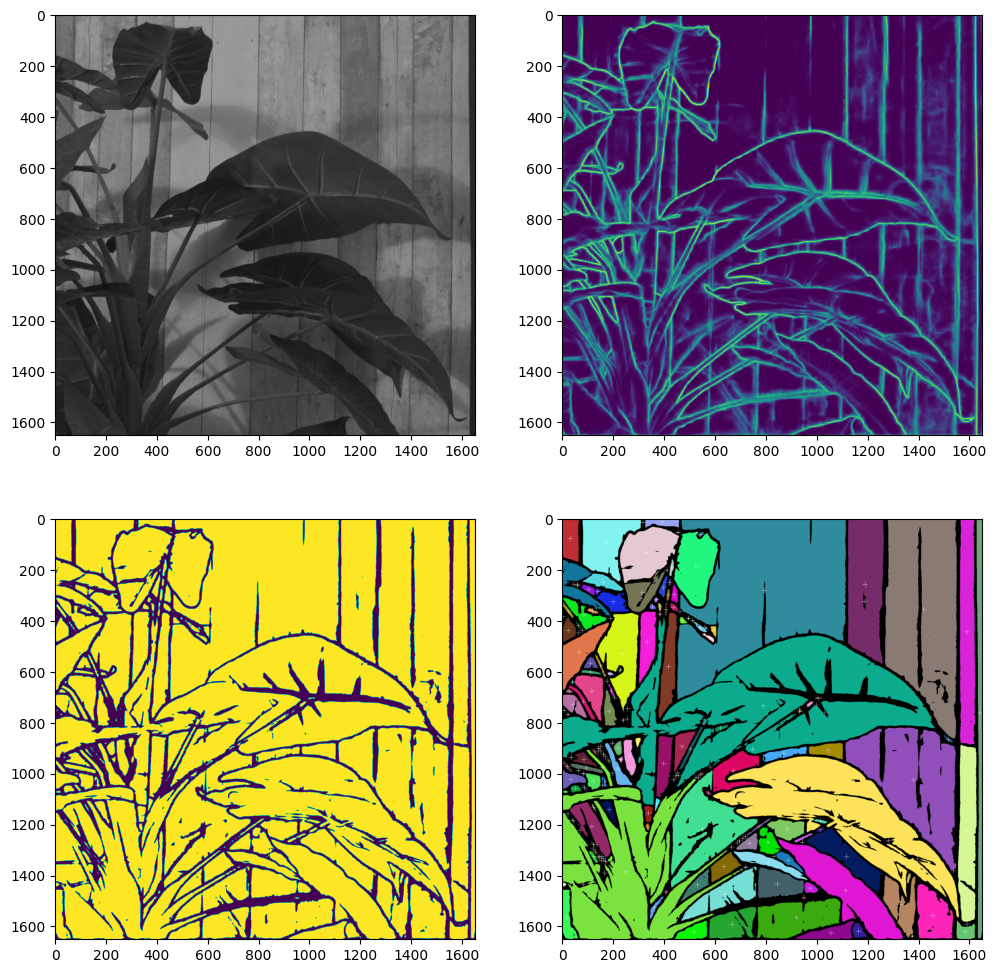

In [79]:
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(hed)
plt.subplot(223)
plt.imshow(thresh)
plt.subplot(224)
plt.imshow(false_colors_centroid) 
plt.show()